<div class="alert alert-success">
    <h1 align="center"> Image Classification (plants)</h1>
    <h3 align="center">Kian Karimi</a></h3>
</div>

<h6 align='center'>Kaggle competition:     <strong>[Plant Seeldlings Competition](https://www.kaggle.com/c/plant-seedlings-classification)</strong></h6>

## Libraries

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import math
import time
import os
import glob

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

import torchvision
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms

# some initial setup
np.set_printoptions(precision=2)
use_gpu = torch.cuda.is_available()
np.random.seed(1234)

In [2]:
# libraries
from train_final import train_model
from model_utils_final import *
from predict_utils_final import *
from vis_utils_final import *

Using TensorFlow backend.


In [3]:
use_gpu

True

## Data

In [4]:
DATA_DIR = './data_plants/'
sz = 224
batch_size = 8

In [5]:
os.listdir(DATA_DIR)

['test1', 'train', 'test', 'val']

In [6]:
trn_dir = f'{DATA_DIR}train'
val_dir = f'{DATA_DIR}val'

In [7]:
os.listdir(trn_dir)

['Charlock',
 'Shepherds Purse',
 'Common Chickweed',
 'Common wheat',
 'Fat Hen',
 'Cleavers',
 'Loose Silky-bent',
 'Maize',
 'Small-flowered Cranesbill',
 'Black-grass',
 'Scentless Mayweed',
 'Sugar beet']

In [8]:
os.listdir(val_dir)

['maize',
 'scentless mayweed',
 'loose silky_bent',
 'black_grass',
 'fat hen',
 'charlock',
 'cleavers',
 'common chickweek',
 'common wheat',
 'shepherds purse',
 'small-flowered cranebill',
 'sugar beet']

In [9]:
trn_fnames = glob.glob(f'{trn_dir}/*/*.png')
trn_fnames[:5]

['./data_plants/train/Charlock/6b0964b5e.png',
 './data_plants/train/Charlock/b207ff8b2.png',
 './data_plants/train/Charlock/f67425c37.png',
 './data_plants/train/Charlock/ae66022e7.png',
 './data_plants/train/Charlock/97907da1a.png']

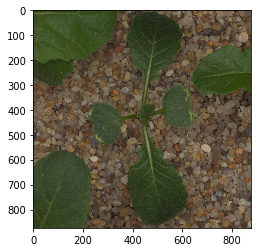

In [10]:
img = plt.imread(trn_fnames[2])
plt.imshow(img);

### Transformations

Dataloader object uses these tranformations when loading data.

In [22]:
# Data augmentation and normalization for training
sz=224
sc=280

import random
zoom = int((1.0 + random.random()/10.0) * sz )

train_transforms = transforms.Compose([
    transforms.Resize((zoom, zoom)),
    transforms.RandomCrop(sz),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.1, 0.1, 0.1, 0.01),
    transforms.RandomRotation(45),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
# Just normalization for validation
valid_transforms = transforms.Compose([
    transforms.Resize((sz, sz)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_ds = datasets.ImageFolder(f'{DATA_DIR}train', train_transforms)
valid_ds = datasets.ImageFolder(f'{DATA_DIR}val', valid_transforms)

train_dl = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = torch.utils.data.DataLoader(valid_ds, batch_size=batch_size, shuffle=True)

train_ds_sz = len(train_ds)
valid_ds_sz = len(valid_ds)

print('Train size: {}\nValid size: {} ({:.2f})'.format(train_ds_sz, valid_ds_sz, valid_ds_sz/(train_ds_sz + valid_ds_sz)))

class_names = train_ds.classes

Train size: 4078
Valid size: 288 (0.07)


#### Accuracy on validation data

In [12]:
def evaluate_model(model, dataloader):
    model.eval()  # for batch normalization layers
    corrects = 0
    for inputs, targets in dataloader:
        inputs, targets = to_var(inputs, True), to_var(targets, True)
        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)
        corrects += (preds == targets.data).sum()
    
    print('accuracy: {:.2f}'.format(100. * corrects / len(dataloader.dataset)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


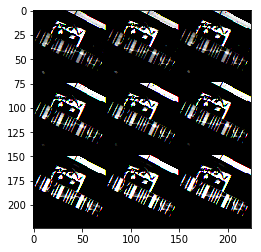

In [13]:
img =train_ds[19][0].numpy()
plt.imshow(img.reshape(sz,sz,3));

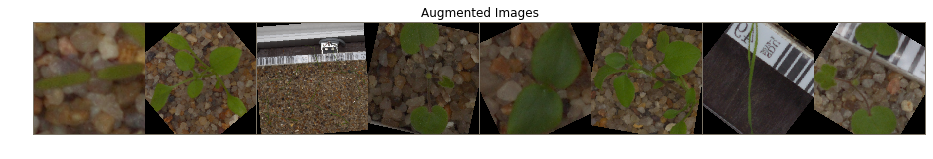

In [14]:
inputs, targets = next(iter(train_dl))     # Get a batch of training data
out = torchvision.utils.make_grid(inputs)  # Make a grid from batch
plt.figure(figsize=(16., 12.))
imshow(out, title='Augmented Images');

#### Look at the sizes of the images

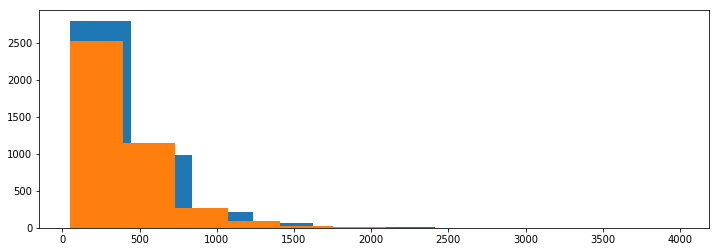

In [15]:
fnames = glob.glob(f'{trn_dir}/*/*.png')
sizes = [Image.open(f).size for f in fnames]

hs, ws = list(zip(*sizes))

plt.figure(figsize=(12., 4.))
plt.hist(hs)
plt.hist(ws);

In [25]:
# load pre-trained ResNet50

model = load_pretrained_resnet50(model_path=None, num_classes=12)
if use_gpu:
    model = model.cuda()

# loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.002, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.9)

In [26]:
model = train_model(model, train_dl, valid_dl, criterion, optimizer, scheduler, num_epochs=25)

Epoch 1/25
----------
  train Loss: 0.86197 Acc: 0.72437
  Step 0/36 | Loss: 0.11411

/home/kian/Desktop/Plants/utils.py:21: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(x, volatile=volatile)


  valid Loss: 0.36727 Acc: 0.86458

Epoch 2/25
----------
  train Loss: 0.41526 Acc: 0.85875
  valid Loss: 0.36790 Acc: 0.89583

Epoch 3/25
----------
  train Loss: 0.30453 Acc: 0.89063
  valid Loss: 0.19620 Acc: 0.94444

Epoch 4/25
----------
  train Loss: 0.25510 Acc: 0.91417
  valid Loss: 0.17043 Acc: 0.94444

Epoch 5/25
----------
  train Loss: 0.20267 Acc: 0.92864
  valid Loss: 0.15826 Acc: 0.94792

Epoch 6/25
----------
  train Loss: 0.15265 Acc: 0.94875
  valid Loss: 0.16847 Acc: 0.95486

Epoch 7/25
----------
  train Loss: 0.13273 Acc: 0.95120
  valid Loss: 0.18172 Acc: 0.94097

Epoch 8/25
----------
  train Loss: 0.13883 Acc: 0.94679
  valid Loss: 0.14056 Acc: 0.96181

Epoch 9/25
----------
  train Loss: 0.11483 Acc: 0.96052
  valid Loss: 0.19141 Acc: 0.94097

Epoch 10/25
----------
  train Loss: 0.09158 Acc: 0.96739
  valid Loss: 0.10544 Acc: 0.97222

Epoch 11/25
----------
  train Loss: 0.09071 Acc: 0.96665
  valid Loss: 0.08463 Acc: 0.98264

Epoch 12/25
----------
  train L

In [27]:
evaluate_model(model, valid_dl)

/home/kian/Desktop/Plants/utils.py:21: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(x, volatile=volatile)


accuracy: 97.00


/home/kian/Desktop/Plants/utils.py:21: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(x, volatile=volatile)


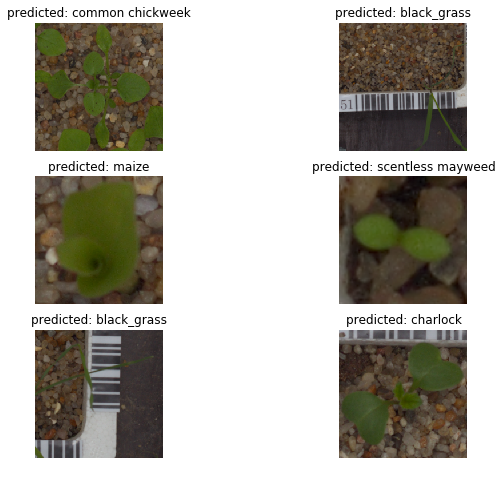

In [28]:
visualize_model(model, valid_dl, num_images=6)

  0%|          | 0/36 [00:00<?, ?it/s]/home/kian/Desktop/Plants/utils.py:21: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(x, volatile=volatile)
100%|██████████| 36/36 [00:03<00:00,  8.29it/s]


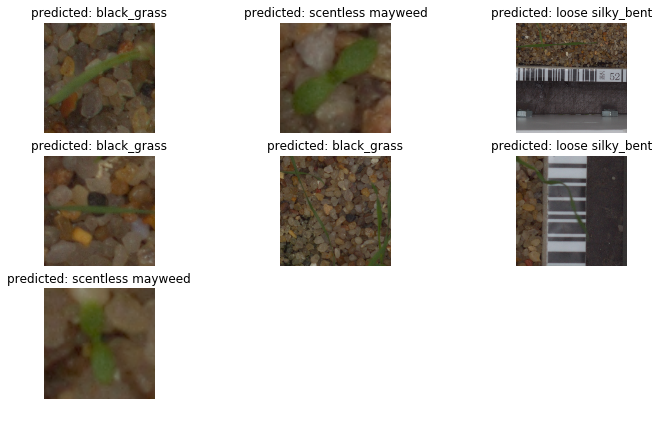

7 images out of 288 were misclassified.


In [29]:
plot_errors(model, valid_dl)